# Detection Layer

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
!pip install deslib
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap
!pip install scikit-posthocs
import scikit_posthocs as sp
from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier
!pip install scikit-optimize
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Preparation before training

In [15]:
# Call Dataset
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DES4Depression/code/3labelv4Classification.csv')
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Columns: 317 entries, GENDER to depression_category
dtypes: float64(47), int64(1), object(269)
memory usage: 6.7+ MB


In [16]:
# All categorical features except for label
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
categorical_features.remove('depression_category')

# Label Encode all categorical, but keep missing values
le_initial_df = initial_df.copy()
dropped_labels = le_initial_df['depression_category']
le_initial_df = le_initial_df.drop('depression_category', axis = 1)

for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')

        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])

        missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]

        le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)

le_initial_df = pd.concat([le_initial_df, dropped_labels], axis = 1)

In [17]:
le_initial_df

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC4,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,depression_category
0,1,62,0,5,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,normal
1,1,79,2,2,2,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,normal
2,0,58,0,4,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,normal
3,0,79,2,5,3,2,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,normal
4,1,68,1,6,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,1,61,0,1,0,2,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,moderatesevere
2759,1,70,1,1,0,4,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,10.0,2.0,moderatesevere
2760,1,70,1,3,2,2,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,moderatesevere
2761,0,63,0,4,3,2,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,moderatesevere


In [18]:
# Seperate and Combine
le_df_normal = le_initial_df[le_initial_df['depression_category'] == 'normal']
le_df_mild = le_initial_df[le_initial_df['depression_category'] == 'mild']
le_df_moderatesevere = le_initial_df[le_initial_df['depression_category'] == 'moderatesevere']

le_df_depression = pd.concat([le_df_mild, le_df_moderatesevere], ignore_index = False)

le_df_depression['depression_category'] = 'depression'

# Check depression category counts
dataframes = [le_df_normal, le_df_depression]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['depression_category'].value_counts()
label_counts

,count
depression_category,
depression,1455
normal,1308


In [19]:
# Some outlier
threshold = int(0.8 * le_df_normal.shape[1])
le_df_normal = le_df_normal.dropna(thresh = threshold)
threshold = int(0.8 * le_df_depression.shape[1])
le_df_depression = le_df_depression.dropna(thresh = threshold)

# Check depression category counts
dataframes = [le_df_normal, le_df_depression]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['depression_category'].value_counts()

In [20]:
# Imputation
different_le_dfs = [le_df_normal, le_df_depression]
imputed_le_dfs = []
from sklearn.impute import IterativeImputer
for le_df in different_le_dfs:
    y = le_df['depression_category']
    X = le_df.drop('depression_category', axis = 1)

    imputer = SimpleImputer(strategy='median')
    imputed_data = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_data, columns = X.columns)

    imputed_df['depression_category'] = y.reset_index(drop = True)
    imputed_le_dfs.append(imputed_df)

concatenated_le_dfs = pd.concat(imputed_le_dfs, ignore_index = True)
concatenated_le_dfs

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC4,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,depression_category
0,1.0,62.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,normal
1,1.0,79.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,normal
2,0.0,58.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,normal
3,0.0,79.0,2.0,5.0,3.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,normal
4,1.0,68.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,1.0,61.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,depression
2603,1.0,70.0,1.0,1.0,0.0,4.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,2.0,depression
2604,1.0,70.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,depression
2605,0.0,63.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,depression


In [21]:
# Full label encode depression category
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()
fully_LE_concatenated_le_dfs['depression_category'] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs['depression_category'])

# The dataset after category connect, imputation, and label encoding
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
splitted_dataset

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC4,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,depression_category
0,1.0,62.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,1
1,1.0,79.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,1
2,0.0,58.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,1
3,0.0,79.0,2.0,5.0,3.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,1
4,1.0,68.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2602,1.0,61.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,0
2603,1.0,70.0,1.0,1.0,0.0,4.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,2.0,0
2604,1.0,70.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,0
2605,0.0,63.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,0


### Setup for training

In [22]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4,
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc="lower right", fontsize=22, frameon=True, framealpha=0.9)
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg')
    plt.show()

    display(FileLink(filename))

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.

    This function is deprecated and will be removed in Orange 3.34.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    This function is deprecated and will be removed in Orange 3.34.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize = 14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    if hasattr(clf, 'predict_proba'):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc

In [23]:
warnings.filterwarnings('ignore')

### Training (classic/static)
In order to run classical/static, make sure to uncomment the one you need. "Post Training" is after one of these classical/static is done.

#### Classical Classifiers

In [24]:
#Optimized Classifiers
classifiers = {
     'DT': DecisionTreeClassifier(
         random_state=0,
         criterion='gini',
         max_depth=6,
         min_samples_leaf=10,
         min_samples_split=9
     ),
     'LR': LogisticRegression(
         random_state=0,
         C=0.09659168435718246,
         max_iter=100,
         solver='lbfgs'
     ),
     'NB': GaussianNB(
         var_smoothing=0.0058873326349240295
     ),
     'KN': KNeighborsClassifier(
         metric='manhattan',
         n_neighbors=8,
         weights='uniform'
     ),
     'MLP': MLPClassifier(
         random_state=0,
         max_iter=1000,
         alpha=0.0003079393718075164,
         hidden_layer_sizes=195,
         learning_rate_init=0.0001675266159417717
     ),
     'SVC': SVC(probability=True, kernel = 'rbf', C = 0.95, gamma = 'scale')}

# Default classifiers
# classifiers = {
#     'DecisionTree': DecisionTreeClassifier(random_state=0),
#     'LogisticRegression': LogisticRegression(max_iter=1000, random_state=0),
#     'NaiveBayes': GaussianNB(),
#     'KNeighbors': KNeighborsClassifier(),
#     'MLP': MLPClassifier(max_iter=1000, random_state=0),
#     'SVC': SVC(probability=True, random_state=0)
# }

# Main
# Initialize
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

# Loop over 10 different random states
for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    # Splitting the data
    X = splitted_dataset.drop('depression_category', axis=1)
    y = splitted_dataset['depression_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    # Identify outliers in the training dataset
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    # Select all rows that are not outliers
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    # SMOTE
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after ROS: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}")

    sampling_strategy_undersample = {0: 372}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)
    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    # Normalization
    scaler = MinMaxScaler()

    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

   # Correlation Feat Analysis
    corr_df = X_res.copy()
    corr_df['target'] = y_res

    corr_mat = corr_df.corr()
    target_correlation = corr_mat['target'].drop('target')
    top_features = target_correlation.abs().sort_values(ascending=False).head(200).index.tolist()

    # Only take top features
    X_res_fi = X_res[top_features]
    X_test_fi = X_test[top_features]

    # Evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Ensure the random state for classifiers is consistent
        if hasattr(clf, 'random_state'):
            clf.set_params(random_state=random_state)
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        roc_curves[clf_name].append((fpr, tpr))
        roc_aucs[clf_name].append(roc_auc)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after ROS: depression_category
0    910
1    910
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    372
Name: count, dtype: int64
Number of test labels after resampling: depression_category
0    372
1    372
Name: count, dtype: int64
DT - Accuracy: 0.7728, Precision: 0.7729, Recall: 0.7728, F1-Score: 0.7728
LR - Accuracy: 0.7809, Precision: 0.7811, Recall: 0.7809, F1-Score: 0.7809
NB - Accuracy: 0.6949, Precision: 0.6955, Recall: 0.6949, F1-Score: 0.6946
KN - Accuracy: 0.6720, Precision: 0.7099, Recall: 0.6720, F1-Score: 0.6566
MLP - Accuracy: 0.7769, Precision: 0.7816, Recall: 0.7769, F1-Score: 0.7759
SVC - Accuracy: 0.7957, Precision: 0.7958, Recall: 0.7957, F1-Score: 0.7957
Processing for Random State: 1
Number of training labels after ROS: depression_category
1    917
0    917
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    

#### Static Classifiers

In [25]:
# Initialize
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

# Optimized Classifiers
classifiers = {
    'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
    # 'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
    # 'CB': CatBoostClassifier(depth = 3, iterations = 168, learning_rate = 0.1, verbose = 0),
    # 'LGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200)
}

# Default Classifiers
# classifiers = {
#     'RandomForest': RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=7, random_state=0),
#     'XGBoost': XGBClassifier(n_estimators=100, max_depth=7, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
#     'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=0),
#     'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=0),
#     'CatBoost': CatBoostClassifier(n_estimators=100, verbose=0, random_state=0),
#     'LightGBM': LGBMClassifier(n_estimators=100, random_state=0)
# }

# voting_clf = VotingClassifier(estimators=[
#     ('rf', classifiers['RF']),
#     ('xgb', classifiers['XGB']),
#     ('gb', classifiers['GB']),
#     ('ada', classifiers['AB']),
#     ('cat', classifiers['CB']),
#     ('lgbm', classifiers['LGBM'])
# ], voting='soft', n_jobs=1)

# classifiers['Vot'] = voting_clf

# Define the number of features for each classifier
num_features = {
     'RF': 150,
     'XGB': 150,
     'GB': 150,
     # 'AB': 150,
     # 'CB': 150,
     # 'LGBM': 150,
     # 'Vot': 150
}

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('depression_category', axis=1)
    y = splitted_dataset['depression_category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after ROS: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}")

    sampling_strategy_undersample = {0: 372}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()

    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)

    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices]

    for clf_name, clf in classifiers.items():
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]

        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]

        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
        )
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        roc_curves[clf_name].append((fpr, tpr))
        roc_aucs[clf_name].append(roc_auc)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 0
Number of training labels after ROS: depression_category
0    910
1    910
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    372
Name: count, dtype: int64
Number of test labels after resampling: depression_category
0    372
1    372
Name: count, dtype: int64
RF - Accuracy: 0.8266, Precision: 0.8275, Recall: 0.8266, F1-Score: 0.8265
XGB - Accuracy: 0.8508, Precision: 0.8512, Recall: 0.8508, F1-Score: 0.8508
GB - Accuracy: 0.8508, Precision: 0.8515, Recall: 0.8508, F1-Score: 0.8507
Processing for Random State: 1
Number of training labels after ROS: depression_category
1    917
0    917
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    372
Name: count, dtype: int64
Number of test labels after resampling: depression_category
0    372
1    372
Name: count, dtype: int64
RF - Accuracy: 0.8387, Precision: 0.8388, Recall: 0.8387, F1-Score: 0.8387
XGB - Accuracy: 0

### Post Training (classic/static)
Only run after one of the training methods above are done

In [26]:
print('\nAverage Metrics over 10 Random States:')
for clf_name, metrics in metric_sums.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[clf_name])
    std_precision = np.std(precision_scores[clf_name])
    std_recall = np.std(recall_scores[clf_name])
    std_f1 = np.std(f1_scores[clf_name])
    avg_auc = np.mean(roc_aucs[clf_name])
    print(f'{clf_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')


Average Metrics over 10 Random States:
RF - Accuracy: 0.8288 ± 0.0111, Precision: 0.8290 ± 0.0110, Recall: 0.8288 ± 0.0111, F1-Score: 0.8287 ± 0.0111, AUC: 0.9103
XGB - Accuracy: 0.8698 ± 0.0100, Precision: 0.8700 ± 0.0099, Recall: 0.8698 ± 0.0100, F1-Score: 0.8697 ± 0.0100, AUC: 0.9417
GB - Accuracy: 0.8690 ± 0.0133, Precision: 0.8694 ± 0.0133, Recall: 0.8690 ± 0.0133, F1-Score: 0.8689 ± 0.0133, AUC: 0.9401


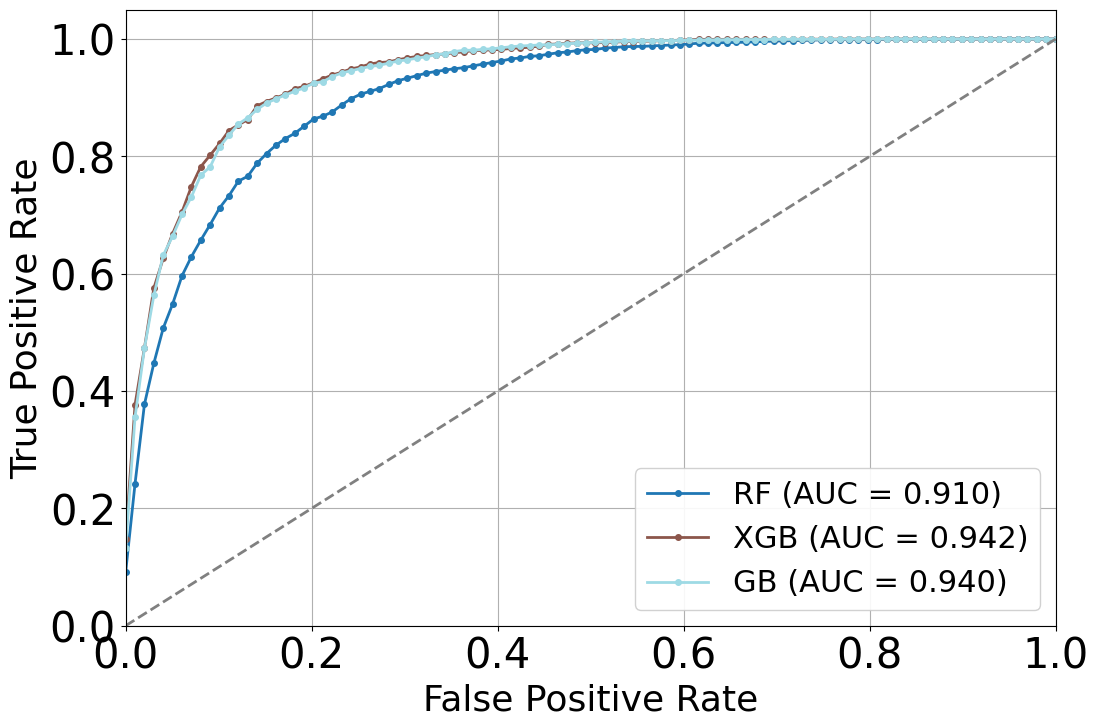

/content/bonk.svg

In [27]:
# Plot ROC Curves for each classifier in one graph
plot_combined_roc_curve(roc_curves, classifiers.keys())

Friedman Test Statistic: 15.435897435897449, p-value: 0.00044477202166078673
Critical Difference: 1.0481349509868467


<Figure size 1400x800 with 0 Axes>

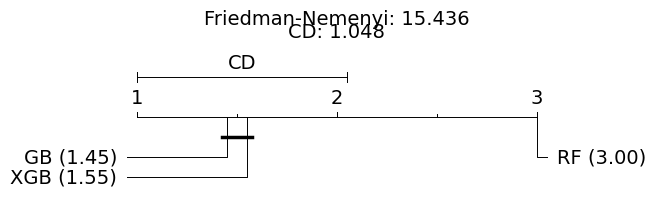

In [28]:
# FN Curve
df = pd.DataFrame(accuracy_scores)
scores = [df[col].values for col in df.columns]
stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')
ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values
n_datasets = df.shape[0]
alpha = 0.05
cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')
classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
plt.figure(figsize=(14, 8))
graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
plt.tight_layout()

### Hyperparameter optimization (classic/static)

In [32]:
# Hyperparameter optimization classic
search_spaces = {
    'DecisionTree': {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(1, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    },
    'LogisticRegression': {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'solver': Categorical(['lbfgs', 'liblinear']),
        'max_iter': Integer(100, 1000)
    },
    'NaiveBayes': {
        'var_smoothing': Real(1e-9, 1e-2, prior='log-uniform')
    },
    'KNeighbors': {
        'n_neighbors': Integer(1, 30),
        'weights': Categorical(['uniform', 'distance']),
        'metric': Categorical(['euclidean', 'manhattan', 'minkowski'])
    },
    'MLP': {
        'hidden_layer_sizes': Integer(50, 200),
        'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
        'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
    },
    'SVC': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
}

classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=0),
    'NaiveBayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=0),
    'SVC': SVC(probability=True, random_state=0)
}

top_features_count = {
    'DecisionTree': 200,
    'LogisticRegression': 200,
    'NaiveBayes': 200,
    'KNeighbors': 200,
    'MLP': 200,
    'SVC': 200
}

random_state = 0
print(f"Processing for Random State: {random_state}")

X = splitted_dataset.drop('depression_category', axis=1)
y = splitted_dataset['depression_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after ROS: {y_res.value_counts()}")

print(f"Number of test labels before resampling: {y_test.value_counts()}")

sampling_strategy_undersample = {0: 372}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
X_test, y_test = rus.fit_resample(X_test, y_test)
print(f"Number of test labels after resampling: {y_test.value_counts()}")

scaler = MinMaxScaler()

X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

X_res = pd.DataFrame(X_res, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

corr_df = X_res.copy()
corr_df['target'] = y_res

corr_mat = corr_df.corr()
target_correlation = corr_mat['target'].drop('target')

for clf_name, clf in classifiers.items():
    print(f"Optimizing {clf_name}")

    top_features = target_correlation.abs().sort_values(ascending=False).head(top_features_count[clf_name]).index.tolist()

    X_res_fi = X_res[top_features]
    X_test_fi = X_test[top_features]

    # Changed n_jobs from -1 to 1 to disable parallel processing
    opt = BayesSearchCV(clf, search_spaces[clf_name], n_iter=30, cv=3, random_state=random_state, n_jobs=1, verbose = 30)
    opt.fit(X_res_fi, y_res)

    best_clf = opt.best_estimator_
    best_params = opt.best_params_

    print(f"Best parameters for {clf_name}: {best_params}")

    accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(best_clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
    print(f"Best results for {clf_name}:")
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
    print(conf_matrix)
    print()

Processing for Random State: 0
Number of training labels after ROS: depression_category
0    910
1    910
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    372
Name: count, dtype: int64
Number of test labels after resampling: depression_category
0    372
1    372
Name: count, dtype: int64
Optimizing DecisionTree
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START criterion=entropy, max_depth=14, min_samples_leaf=7, min_samples_split=7
[CV 1/3; 1/1] END criterion=entropy, max_depth=14, min_samples_leaf=7, min_samples_split=7;, score=0.778 total time=   0.2s
[CV 2/3; 1/1] START criterion=entropy, max_depth=14, min_samples_leaf=7, min_samples_split=7
[CV 2/3; 1/1] END criterion=entropy, max_depth=14, min_samples_leaf=7, min_samples_split=7;, score=0.784 total time=   0.2s
[CV 3/3; 1/1] START criterion=entropy, max_depth=14, min_samples_leaf=7, min_samples_split=7
[CV 3/3; 1/1] END criterion=entropy, max_depth=14

In [36]:
# Hyperparameter optimization static
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'LightGBM': LGBMClassifier()
}

num_features = {
     'RandomForest': 150,
     'XGBoost': 150,
     'GradientBoosting': 150,
     'AdaBoost': 150,
     'CatBoost': 150,
     'LightGBM': 150,
}

search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.9, 1.0],
    }
}

def hyperparameter_optimization(clf, search_space, X, y):
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        # Change n_jobs from -1 to 1 to avoid multiprocessing issues
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

# Rest of the code remains the same
metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
conf_matrices = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)

classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'LightGBM': LGBMClassifier()
}

num_features = {
     'RandomForest': 150,
     'XGBoost': 150,
     'GradientBoosting': 150,
     'AdaBoost': 150,
     'CatBoost': 150,
     'LightGBM': 150,
}

search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 63, 127],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.9, 1.0],
    }
}


for random_state in range(9,10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('depression_category', axis=1)
    y = splitted_dataset['depression_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after ROS: {y_res.value_counts()}")

    print(f"Number of test labels before resampling: {y_test.value_counts()}")

    sampling_strategy_undersample = {0: 372}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()

    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)

    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:300]]

    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]

        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]

        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)

        # Ensure integer parameters are cast to int
        if 'n_estimators' in best_params:
            best_params['n_estimators'] = int(best_params['n_estimators'])
        if 'max_depth' in best_params:
            best_params['max_depth'] = int(best_params['max_depth'])
        if 'iterations' in best_params:
            best_params['iterations'] = int(best_params['iterations'])
        # Add casting for LightGBM specific parameters if they exist
        if 'num_leaves' in best_params:
            best_params['num_leaves'] = int(best_params['num_leaves'])

        clf.set_params(**best_params)
        print(f"Best parameters for {clf_name}: {best_params}")

        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        metric_sums[clf_name]['accuracy'] += accuracy
        metric_sums[clf_name]['precision'] += precision
        metric_sums[clf_name]['recall'] += recall
        metric_sums[clf_name]['f1'] += f1
        conf_matrices[clf_name].append(conf_matrix)
        accuracy_scores[clf_name].append(accuracy)
        precision_scores[clf_name].append(precision)
        recall_scores[clf_name].append(recall)
        f1_scores[clf_name].append(f1)

Processing for Random State: 9
Number of training labels after ROS: depression_category
0    918
1    918
Name: count, dtype: int64
Number of test labels before resampling: depression_category
0    411
1    372
Name: count, dtype: int64
Number of test labels after resampling: depression_category
0    372
1    372
Name: count, dtype: int64
Optimizing RandomForest


KeyboardInterrupt: 

### DES Training (all)

In [ ]:
metric_sums_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

conf_matrices_des = {
    'KNORAE': [],
    'KNORAU': [],
    'KNOP': [],
    'DESMI': [],
    'METADES': [],
    'DESKNN': [],
    'DESP': [],
    'FIRE-KNORA-U': [],
    'FIRE-KNORA-E': [],
    'FIRE-METADES': [],
    'FIRE-DESKNN': [],
    'FIRE-DESP': [],
    'FIRE-KNOP': [],
}

roc_curves = defaultdict(list)
roc_aucs = defaultdict(list)
accuracy_scores = defaultdict(list)
precision_scores = defaultdict(list)
recall_scores = defaultdict(list)
f1_scores = defaultdict(list)
feature_importance_runs = []

# Uncomment wanted combinations
base_classifiers = {
    # 'DecisionTree': DecisionTreeClassifier(
    #     random_state=0,
    #     criterion='gini',
    #     max_depth=6,
    #     min_samples_leaf=10,
    #     min_samples_split=9
    # ),
    # 'LogisticRegression': LogisticRegression(
    #     random_state=0,
    #     C=0.09659168435718246,
    #     max_iter=100,
    #     solver='lbfgs'
    # ),
    # 'NaiveBayes': GaussianNB(
    #     var_smoothing=0.0058873326349240295
    # ),
    # 'KNeighbors': KNeighborsClassifier(
    #     metric='manhattan',
    #     n_neighbors=15,
    #     weights='uniform'
    # ),
    # 'MLP': MLPClassifier(
    #     random_state=0,
    #     max_iter=1000,
    #     alpha=0.0003079393718075164,
    #     hidden_layer_sizes=195,
    #     learning_rate_init=0.0001675266159417717
    # ),
    # 'SVC': SVC(probability=True, kernel = 'rbf', C = 1.5, gamma = 'auto'),
    # 'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
    'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
    # 'CB': CatBoostClassifier(depth = 3, iterations = 168, learning_rate = 0.1, verbose = 0),
    # 'LGBM': LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 200)
}

random_state = 0

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('depression_category', axis=1)
    y = splitted_dataset['depression_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    sampling_strategy_undersample = {0: 372}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    xgb_fs = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs.fit(X_res, y_res)

    feature_importances = xgb_fs.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_50_features = [original_columns[i] for i in indices[:50]]
    current_run_features = {original_columns[i]: feature_importances[i] for i in indices[:50]}

    feature_importance_runs.append(current_run_features)

    X_res_fi = X_res[top_50_features]
    X_test_fi = X_test[top_50_features]

    model_pool = list(base_classifiers.values())

    for clf in model_pool:
        clf.fit(X_res_fi, y_res)

    des_models = {
        'KNORAE': KNORAE(pool_classifiers=model_pool, random_state=random_state),
        'KNORAU': KNORAU(pool_classifiers=model_pool, random_state=random_state),
        'DESMI': DESMI(pool_classifiers=model_pool, random_state=random_state),
        'METADES': METADES(pool_classifiers=model_pool, random_state=random_state),
        'DESKNN': DESKNN(pool_classifiers=model_pool, random_state=random_state),
        'DESP': DESP(pool_classifiers=model_pool, random_state=random_state),
        'KNOP': KNOP(pool_classifiers=model_pool, random_state=random_state, k=9),
        'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40, random_state = random_state)
    }

    for des_name, des_model in des_models.items():
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            des_model, X_res_fi, y_res, X_test_fi, y_test, clf_name=des_name
        )
        metric_sums_des[des_name]['accuracy'] += accuracy
        metric_sums_des[des_name]['precision'] += precision
        metric_sums_des[des_name]['recall'] += recall
        metric_sums_des[des_name]['f1'] += f1
        conf_matrices_des[des_name].append(conf_matrix)
        roc_curves[des_name].append((fpr, tpr))
        roc_aucs[des_name].append(roc_auc)
        accuracy_scores[des_name].append(accuracy)
        precision_scores[des_name].append(precision)
        recall_scores[des_name].append(recall)
        f1_scores[des_name].append(f1)

        print(f'Confusion Matrix for {des_name} at Random State {random_state}:\n{conf_matrix}\n')

In [ ]:
def plot_combined_roc_curve(roc_curves, classifier_names):
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    for i, clf_name in enumerate(classifier_names):
        tprs = []
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2, linestyle='-', marker='o', markersize=4,
                 label=f'{clf_name} (AUC = {mean_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=26)
    plt.ylabel('True Positive Rate', fontsize=26)
    plt.xticks(fontsize=30)  # Increase x-axis numbers font size
    plt.yticks(fontsize=30)  # Increase y-axis numbers font size
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=26, frameon=True, framealpha=0.9)  # Place legend beside the plot
    plt.grid(True)

    filename='bonk.svg'

    plt.savefig(filename, format='svg', bbox_inches = 'tight')
    plt.show()

    display(FileLink(filename))

In [ ]:
print('\nAverage Metrics over 10 Random States:')
for des_name, metrics in metric_sums_des.items():
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    std_accuracy = np.std(accuracy_scores[des_name])
    std_precision = np.std(precision_scores[des_name])
    std_recall = np.std(recall_scores[des_name])
    std_f1 = np.std(f1_scores[des_name])
    avg_auc = np.mean(roc_aucs[des_name])
    print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')

plot_combined_roc_curve(roc_curves, list(des_models.keys()))

In [ ]:
df = pd.DataFrame(accuracy_scores)
scores = [df[col].values for col in df.columns]

stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')

ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values

n_datasets = df.shape[0]
alpha = 0.05

cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')

classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]

plt.figure(figsize=(14, 10))

graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.xlabel('Classifiers')

plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()

### Shap (will mostly be exported files)

In [ ]:
# Example with XGB

random_state = 2
print(f"Processing for Random State: {random_state}")

X = splitted_dataset.drop('depression_category', axis=1)
y = splitted_dataset['depression_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after SMOTE: {y_res.value_counts()}")
print(f"Number of test labels before resampling: {y_test.value_counts()}")

sampling_strategy_undersample = {0: 372}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
X_test, y_test = rus.fit_resample(X_test, y_test)

print(f"Number of test labels after resampling: {y_test.value_counts()}")

# Normalization
# scaler = MinMaxScaler()
# X_res = scaler.fit_transform(X_res)
# X_test = scaler.transform(X_test)

X_res = pd.DataFrame(X_res, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

# Train XGBoost model on all features
model = xgb.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
model.fit(X_res, y_res)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [ ]:
def plot_shap_waterfall(instance_index, filename):
    shap_value = shap_values[instance_index]
    plt.figure(figsize=(14, 8))

    shap.plots.waterfall(shap_value, show=False)

    ax = plt.gca()

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22)

    plt.tight_layout()

    plt.savefig(filename, format='svg')

    plt.close()

plot_shap_waterfall(0, "waterfall_plot_instance_0.svg")
plot_shap_waterfall(562, "waterfall_plot_instance_562.svg")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
shap.summary_plot(
    shap_values,
    X_res,
    plot_type="bar",
    feature_names=original_columns,
    show=False
)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

plt.savefig("shap_summary_plot.svg", format='svg')
plt.close()

In [ ]:
shap.initjs()

fig, ax = plt.subplots(figsize=(14, 8))

shap.summary_plot(
    shap_values,
    X_res,
    plot_type="dot",
    feature_names=original_columns,
    show=False
)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

fig.savefig("shap_summary_dot_plot.svg", format='svg', bbox_inches='tight')

plt.close(fig)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree

random_state = 5

X = splitted_dataset.drop('depression_category', axis=1)
y = splitted_dataset['depression_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

smote = SMOTE(random_state=random_state)
X_res, y_res = smote.fit_resample(X_train, y_train)

print(f"Number of training labels after ROS: {y_res.value_counts()}")
print(f"Number of test labels before resampling: {y_test.value_counts()}")
sampling_strategy_undersample = {0: 372}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
X_test, y_test = rus.fit_resample(X_test, y_test)

print(f"Number of test labels after resampling: {y_test.value_counts()}")

# Normalization
# scaler = MinMaxScaler()
# X_res = scaler.fit_transform(X_res)
# X_test = scaler.transform(X_test)

X_res = pd.DataFrame(X_res, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

decision_tree_model = DecisionTreeClassifier(
    random_state=0,
    criterion='gini',
    max_depth=6,
    min_samples_leaf=10,
    min_samples_split=9
)
decision_tree_model.fit(X_res, y_res)

plt.figure(figsize=(20, 14))
tree.plot_tree(
    decision_tree_model,
    feature_names=original_columns,
    class_names=['depression', 'normal'],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth = 3
)

plt.savefig("decision_tree_plot.svg", format='svg')
plt.close()

print("Decision Tree plot saved as 'decision_tree_plot.svg'")

In [ ]:
tree_rules = export_text(decision_tree_model, feature_names=original_columns, max_depth=50)
print("Decision rules for the tree (up to depth 3):")
print(tree_rules)

node_indicator = decision_tree_model.decision_path(X_test)

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:node_indicator.indptr[sample_id + 1]]

print(f"\nDecision path for sample {sample_id}:")
for node_id in node_index:
    if X_test.iloc[sample_id, decision_tree_model.tree_.feature[node_id]] <= decision_tree_model.tree_.threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
    print(f"Node {node_id}: (X_test[{sample_id}, {decision_tree_model.tree_.feature[node_id]}] = {X_test.iloc[sample_id, decision_tree_model.tree_.feature[node_id]]}) "
          f"{threshold_sign} {decision_tree_model.tree_.threshold[node_id]}")

# Get prediction for a specific test sample
predicted_class = decision_tree_model.predict([X_test.iloc[sample_id]])
print(f"\nPredicted class for test sample {sample_id}: {predicted_class}")